
* Veri setine ulaşmak için [tıklayınız.](https://www.kaggle.com/c/aptos2019-blindness-detection)

In [1]:
import pandas as pd
import numpy as np

In [2]:
path = '/Users/'

Pandas'ın [.csv okuma modülünü](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) kullanarak, sınıflandırma verilerini jupyter notebook'a aktarıyoruz.

In [3]:
df = pd.read_csv(path + 'train.csv', sep = ',')

In [4]:
df.head()

id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

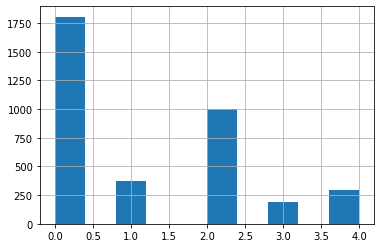

In [5]:
df['diagnosis'].hist()
df['diagnosis'].value_counts()

Retinopati görüntülerini aktarmak için, **os.listdir()** kullanarak *''train_img''* klasöründe bulunan dosyaların isimlerini *''files''* ismine atadım.
* '000c1434d8d7.png'
* '001639a390f0.png'
* '0024cdab0c1e.png'
*  ...

In [6]:
import os
files = os.listdir(path + '/train_img/')
# files

In [7]:
len(files)

3662

In [8]:
import cv2

OpenCV'nin [görüntü okuma modülü](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_gui/py_image_display/py_image_display.html)nü kullanarak **files**'ın içindeki görüntü isimleri üzerinden bir for döngüsü döndürerek görüntüleri okuduk. Ardından bunları (400,400,3) boyutunda yeniden şekillendirdik. OpenCV görüntüleri BGR şeklinde okuduğu için bunları RGB renk koduna çevirdik. Ardından döngüde dönen her görüntüyü *img_list* ismindeki listeye ekledik.

In [9]:
img_list = []

for i in files[0:20]:
    image = cv2.imread(path + '/train_img/'+i)
    image = cv2.resize(image,(400,400))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_list.append(image)

In [10]:
import matplotlib.pyplot as plt

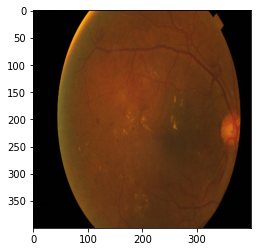

In [11]:
plt.imshow(img_list[0])

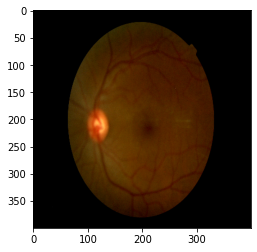

In [12]:
plt.imshow(img_list[4])

In [13]:
kopya = img_list[4].copy()

#### Threshold uygulayabilmek için görüntümüzü siyah-beyaz renklere çevirdik.

In [14]:
kopya = cv2.cvtColor(kopya, cv2.COLOR_RGB2GRAY)

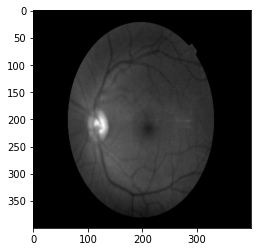

In [15]:
plt.imshow(kopya, cmap='gray')

#### Görüntü siyah beyaz olduğu için RGB kanallarını kaybederek (400,400) boyutuna indirgendi.

In [16]:
kopya.shape

(400, 400)

#### Threshold'un daha başarılı uygulanabilmesi için bir miktar Blur uyguluyoruz.

In [17]:
blur = cv2.GaussianBlur(kopya,(5,5),0)

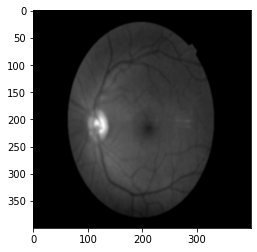

In [18]:
plt.imshow(blur,cmap='gray')

Burada görüntü üzerinde  **10 değerinin üzerinde bulduğu tüm değerleri 255 değerine eşitledik**

In [19]:
thresh = cv2.threshold(blur,10,255, cv2.THRESH_BINARY)[1]

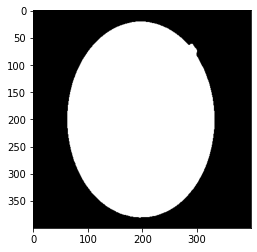

In [20]:
plt.imshow(thresh, cmap='gray')

Kırpma işlemini yapmak için elimizdeki yeni görüntünün **kenar koordinatlarını(kontur)** buluyoruz.

In [21]:
kontur = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [22]:
# kontur

In [23]:
kontur = kontur[0][0]

In [24]:
kontur.shape

(452, 1, 2)

In [25]:
kontur = kontur[:,0,:]

In [26]:
kontur.shape

(452, 2)

In [27]:
# kontur

In [28]:
kontur[:,0].argmax()

335

In [29]:
kontur[335]

array([332, 218], dtype=int32)

In [30]:
kontur[:,0].argmin()

111

In [31]:
kontur[111]

array([ 63, 185], dtype=int32)

In [32]:
sol = tuple(kontur[kontur[:,0].argmin()])
sağ = tuple(kontur[kontur[:,0].argmax()])
üst = tuple(kontur[kontur[:,1].argmin()])
alt = tuple(kontur[kontur[:,1].argmax()])

Görüntümüzün **4 uç noktasına ait koordinatları**nı elde ettik.

In [33]:
sol, sağ, üst, alt

((63, 185), (332, 218), (188, 21), (194, 380))

In [34]:
x1 = sol[0]
y1 = üst[1]
x2 = sağ[0]
y2 = alt[1]

In [35]:
x1, y1, x2, y2

(63, 21, 332, 380)

In [36]:
orijinal = img_list[4].copy()

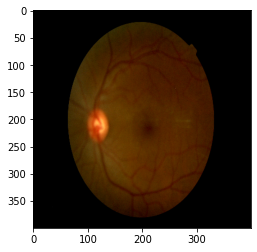

In [37]:
plt.imshow(orijinal)

In [38]:
crop_ilk = orijinal[y1:y2 , x1:x2]

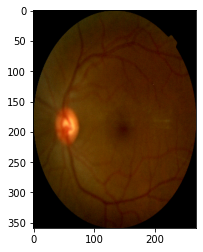

In [39]:
plt.imshow(crop_ilk)

In [40]:
crop_ilk.shape

(359, 269, 3)

Kıprma işlemini yaptıktan sonra görüntü boyut kayması yaşadığı için tekrardan (400,400) boyutuna eşitliyoruz.

In [41]:
crop_ilk = cv2.resize(crop_ilk,(400,400))

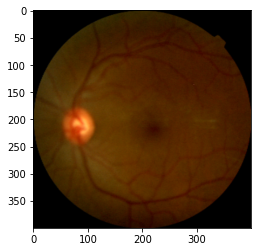

In [42]:
plt.imshow(crop_ilk)

Kenarlardaki veriler gereksiz olduğu için bir eşik belirleyip, bir miktar daha görüntüleri kırpıyoruz.

In [43]:
x = int(x2-x1)*4//100
y = int(y2-y1)*5//100

In [44]:
x,y

(10, 17)

In [45]:
crop_son = orijinal[y1+y : y2-y , x1+x : x2-x]

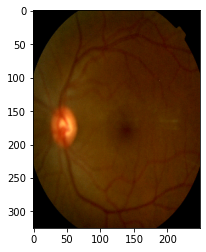

In [46]:
plt.imshow(crop_son)

In [47]:
crop_son = cv2.resize(crop_son,(400,400))

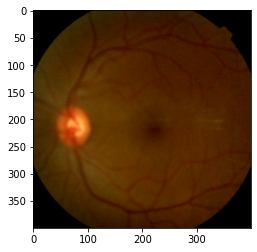

In [48]:
plt.imshow(crop_son)

## CLAHE - Kontrast Limitli Adaptif Histogram Eşitleme

CLAHE uygulamak için renk kanalını RGB'den LAB'a çeviriyoruz.

In [49]:
lab = cv2.cvtColor(crop_son, cv2.COLOR_RGB2LAB)

In [50]:
lab.shape

(400, 400, 3)

In [51]:
l,a,b = cv2.split(lab)

LAB'daki ''l'' görüntünün siyah-beyaz parlaklık değerini içeriyor. CLAHE işlemini sadece bu katmana uygulayacağız. 

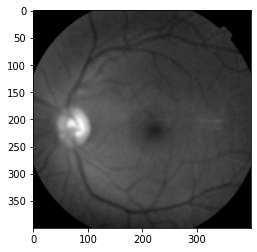

In [52]:
plt.imshow(l, cmap='gray')

In [53]:
l.shape

(400, 400)

In [54]:
düz = l.flatten()

In [55]:
düz.shape

(160000,)

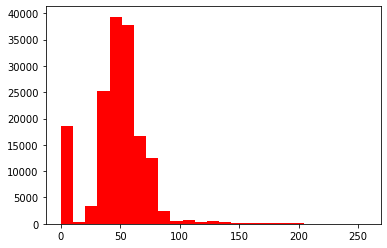

In [56]:
plt.hist(düz,25,[0,256], color = 'r')
plt.show()

In [57]:
clahe = cv2.createCLAHE(clipLimit=7.0,tileGridSize=((8,8)))
cl = clahe.apply(l)

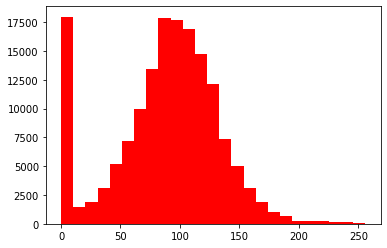

In [58]:
plt.hist(cl.flatten(),25,[0,256], color = 'r')
plt.show()

## CLAHE uygulanmış hali

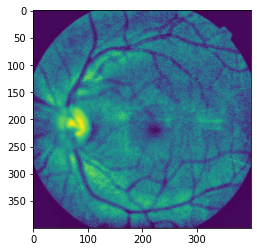

In [59]:
plt.imshow(cl)

## CLAHE uygulanmamış hali


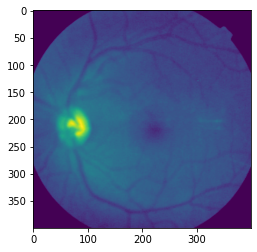

In [60]:
plt.imshow(l)

CLAHE işlemi uyguladığımız katmanı, diğer katmanlarla birleştirip tekrardan görüntümüzü RGB yapıyoruz.

In [61]:
limg = cv2.merge((cl,a,b))

In [62]:
son = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)

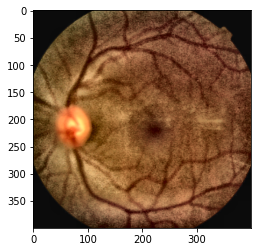

In [63]:
plt.imshow(son)

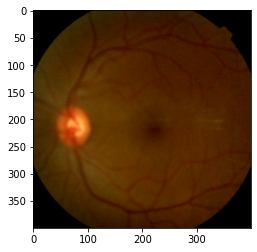

In [64]:
plt.imshow(crop_son)

## Median Blur

In [65]:
med_son = cv2.medianBlur(son, 3)

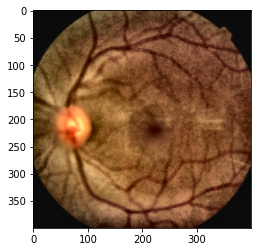

In [66]:
plt.imshow(med_son)

In [67]:
arka_plan = cv2.medianBlur(son, 37)

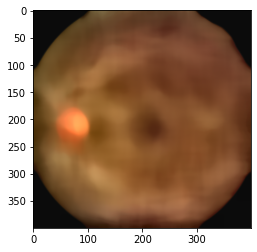

In [68]:
plt.imshow(arka_plan)

# Anevrizma Görünürülüğünü Arttırma

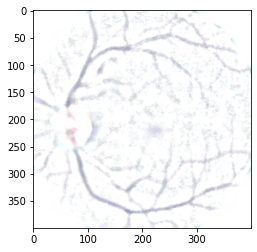

In [69]:
maske = cv2.addWeighted(med_son,1,arka_plan,-1,255)
plt.imshow(maske)

In [70]:
son_img = cv2.bitwise_and(maske,med_son)

# işlemden sonraki hali

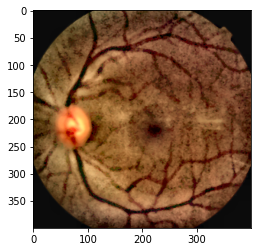

In [71]:
plt.imshow(son_img)

# işlemden önceki hali

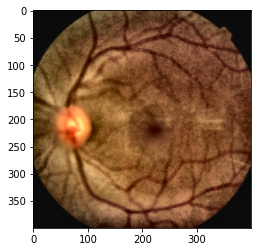

In [72]:
plt.imshow(med_son)

#### Yaptığımız tüm işlemleri tek bir for döngüsünde toplayıp, elimizdeki bütün görüntüleri bu döngüyle img_list ismindeki listeye kaydediyoruz.

In [ ]:
img_list = []

from tqdm import tqdm_notebook as tqdm

for i in tqdm(files):
    image = cv2.imread(path + '/train_img/'+i)
    image = cv2.resize(image,(400,400))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    kopya = image.copy()
    kopya = cv2.cvtColor(kopya, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(kopya,(5,5),0)
    thresh = cv2.threshold(blur,10,255, cv2.THRESH_BINARY)[1]
    kontur = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    kontur = kontur[0][0]
    kontur = kontur[:,0,:]
    x1 = tuple(kontur[kontur[:,0].argmin()])[0]
    y1 = tuple(kontur[kontur[:,1].argmin()])[1]
    x2 = tuple(kontur[kontur[:,0].argmax()])[0]
    y2 = tuple(kontur[kontur[:,1].argmax()])[1]
    x = int(x2-x1)*4//50
    y = int(y2-y1)*5//50
    kopya2 = image.copy()
    if x2-x1 >100 and y2-y1> 100:
        kopya2 = kopya2[y1+y : y2-y , x1+x : x2-x]
        kopya2 = cv2.resize(kopya2,(400,400))
    lab = cv2.cvtColor(kopya2, cv2.COLOR_RGB2LAB)
    l,a,b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=5.0,tileGridSize=((8,8)))
    cl = clahe.apply(l)
    limg = cv2.merge((cl,a,b))
    son = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    med_son = cv2.medianBlur(son, 3)
    arka_plan = cv2.medianBlur(son, 37)
    maske = cv2.addWeighted(med_son,1,arka_plan,-1,255)
    son_img = cv2.bitwise_and(maske,med_son)
    img_list.append(son_img)

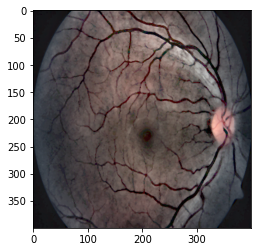

In [74]:
plt.imshow(img_list[6])

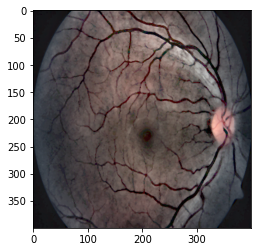

In [75]:
plt.imshow(img_list[6])

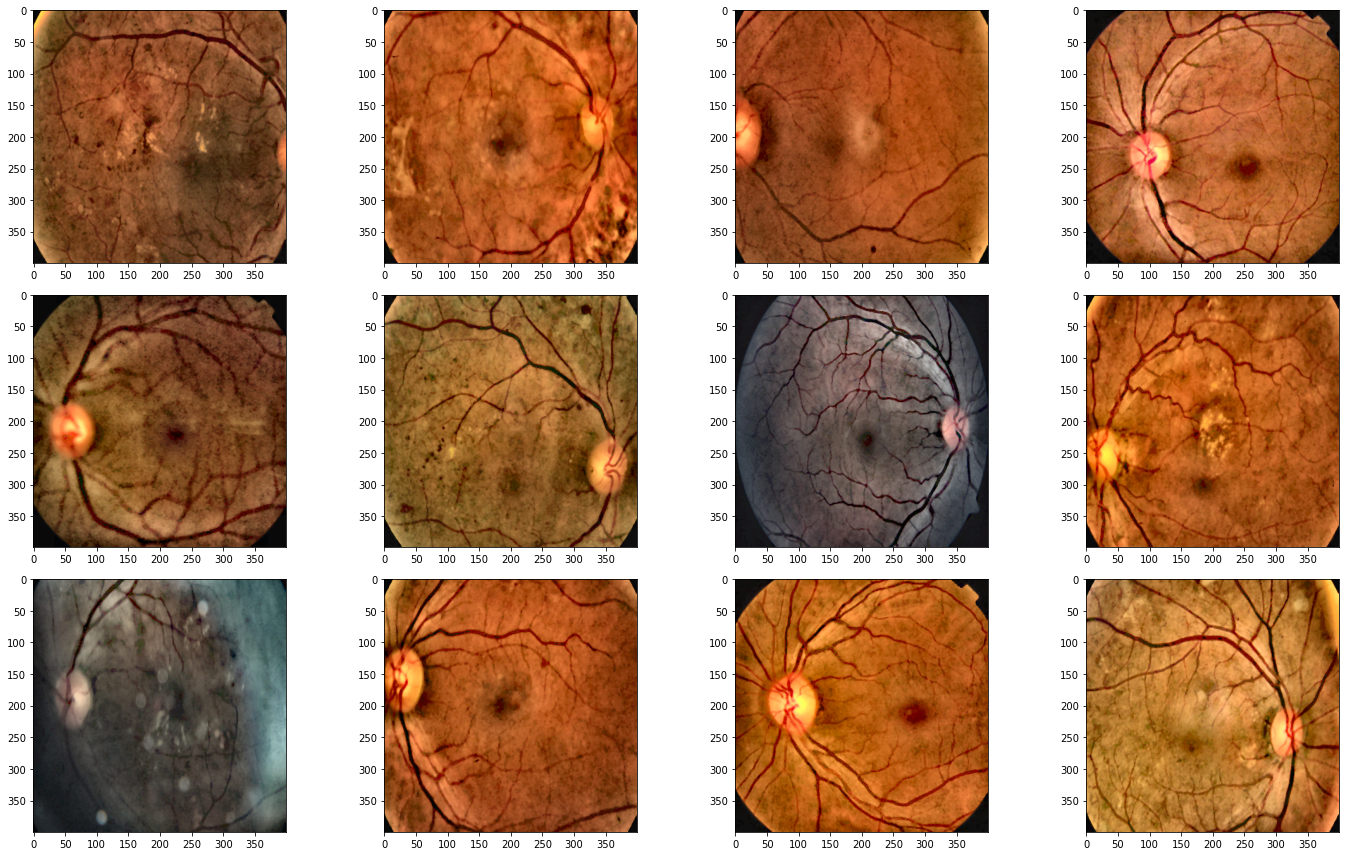

In [76]:
fig = plt.figure(figsize=(20,12))

for i in range(12):
    img = img_list[i]
    fig.add_subplot(3,4,i+1)
    plt.imshow(img)

plt.tight_layout()

In [77]:
# df['diagnosis']

### One Hot Encoding

In [78]:
y_train = pd.get_dummies(df['diagnosis']).values

In [79]:
# y_train

In [80]:
df['diagnosis'][1]

4

In [81]:
y_train[1]

array([0, 0, 0, 0, 1], dtype=uint8)

In [82]:
y_train_son = np.ones(y_train.shape, dtype='uint8')

In [83]:
# y_train_son

In [84]:
y_train_son[:,4] = y_train[:,4]

In [85]:
# y_train_son

In [86]:
import numpy as np

In [87]:
np.logical_or(0,0)

False

In [88]:
np.logical_or(1,0)

True

In [89]:
np.logical_or(0,1)

True

In [90]:
np.logical_or(1,1)

True

In [91]:
np.logical_and(0,1)

False

In [92]:
np.logical_and(1,1)

True

In [93]:
for i in range(3,-1,-1):
    y_train_son[:,i] = np.logical_or(y_train[:,i], y_train_son[:,i+1])

In [94]:
# y_train_son

In [95]:
# y_train

In [96]:
x_train = np.array(img_list)

In [97]:
x_train.shape

(3662, 400, 400, 3)

In [98]:
y_train_son.shape

(3662, 5)

In [99]:
from sklearn.model_selection import train_test_split

x_train, x_val , y_train, y_val = train_test_split(x_train,
                                                   y_train_son,
                                                   test_size=0.15,
                                                   random_state=2019,
                                                   shuffle=True)

In [100]:
x_train.shape, x_val.shape , y_train.shape, y_val.shape

((3112, 400, 400, 3), (550, 400, 400, 3), (3112, 5), (550, 5))

# Veri büyütme (Data Augmentation)

<img src=https://raw.githubusercontent.com/brktzlk/Diyabetik_Retinopati_Teshisi/master/İmages/ret%20sık.png width=1300>

> 1. random rotation 
> 2. horizontal flips
> 3. vertical flips
> 4. horizontal shifts
> 5. vertical shifts
> 6. shear

Retinopati teşhisi modellerinde sık kullanılır.

In [101]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(horizontal_flip=True,vertical_flip=True)
data_generator = datagen.flow(x_train,y_train,batch_size=2,seed=2020)

Using TensorFlow backend.


# Transfer Learning  - EfficientNet


<img src=https://miro.medium.com/max/700/1*jm5MEylOA8abyAi51CcSLA.png width=1300>

In [102]:
from efficientnet.keras import EfficientNetB5

In [103]:
örnek_model = EfficientNetB5()

In [104]:
# örnek_model.summary()

## include_top 
Eğer bu seçeneği **''True''** yaparsanız; model daha önce hangi verilerle eğitildiyse yine o verilere uygun tahmin etme yeteneğine sahip olacaktır. Önreğin daha önce eğitimde uçak,araba,ev gördüyse siz kendi verilerinizle eğitim yapsanız da retinopati görselini gördüğünde uçak mı araba mı olduğunu anlamaya çalışacaktır. Ayrıca Kendi verilerinizle eğitim yapabilmek için önceden eğitilen görüntülerin boyutuna çevirmelisiniz. ImageNet 32x32 görüntülere sahip. Bizim elimizdeki 400x400 görüntüleri 32x32 boyutuna indirgemeliyiz eğitime sokabilmek için. Fakat bunu yapsak bile işimize yaramayacak. Çünkü model, include_top=''True'' yapıldığında ev,araba,uçak vb. görüntülerden başka görüntüyü sınıflandırma yapamaz.

In [105]:
örnek_model2 = EfficientNetB5(include_top=False)
# örnek_model2.summary()

Bu seçeneği **''False''** yaptığımızda modelin sonundaki tahmin yapan kısmı kaldırıyor. Bu sayede kendi verilerimize uygun tahmin katmanı oluşturabiliyoruz.

In [106]:
from keras.models import Sequential
from keras import layers

model = Sequential()
model.add(EfficientNetB5(weights='imagenet',include_top=False, input_shape=(400,400,3)))
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5,activation = 'sigmoid'))

In [107]:
from keras.optimizers import Adam
model.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.00005),metrics=['accuracy'])

In [108]:
from keras.callbacks import ReduceLROnPlateau

lr = ReduceLROnPlateau(monitor = 'val_loss',
                      patience = 3,
                      verbose = 1,
                      mode='auto',
                      factor=0.25,
                      min_lr=0.000001)

In [109]:
history = model.fit_generator(data_generator,
                             steps_per_epoch = 1000,
                             epochs = 1,
                             validation_data = (x_val,y_val),
                             callbacks = [lr])

Epoch 1/1
1000/1000 [==============================] - 617s 617ms/step - loss: 0.3511 - accuracy: 0.8483 - val_loss: 0.1820 - val_accuracy: 0.9418
